### Spectral whitening (normalization)

We use an adaptive weighting function to normalize the complex spectrum of the input waveform before computing the
autocorrelation function. The spectral whitening is defined in a similar way to the running-absolute-mean normalization
[Bensen et al., 2007] in the time domain as 
\begin{equation}
\hat{s}_n = \frac{s_n} {\frac{1}{2N + 1} \sum_{j=n-N}^{n+N} |s_j|}
\end{equation}

The number of averaging points $N$ in the denominator is alternatively refered as
spectral whitening width $\Delta W = 2 N \Delta \omega$, where $\Delta \omega$ is
the discrete frequency step $\Delta \omega = 1/L$ and $L$ is the length of the input time trace.
Tuning the whitening width $\Delta W$ may change the performance of the method. We recommend to do
experiments with this parameter to find an optimal value for your application.

### Import Libraries 

In [1]:
import numpy as np
from scipy.signal import fftconvolve, hilbert
from obspy import read, Stream, Trace
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
from obspy.core import AttribDict

### Generate waveform 

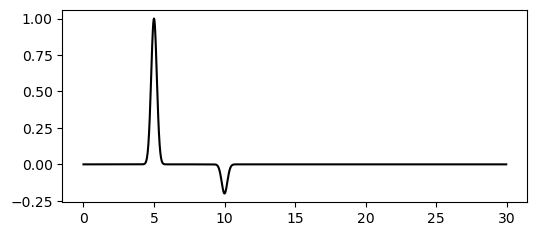

In [2]:
# def Gaussian_function(x,sig,mu):
#     cf=1/(sig*np.sqrt(2*np.pi))
#     exp=np.exp(-1/2*((x-mu)/sig)**2)
#     gauss=cf*exp
#     return gauss

#### using lambda function
Gaussian_function=lambda x,sig,mu:np.exp(-1/2*((x-mu)/sig)**2)/sig*np.sqrt(2*np.pi)

time=np.arange(-2.5,2.5,0.025)
sigma=0.2
gauss_func1=Gaussian_function(time,sigma,0)
gauss_func2=-0.2*Gaussian_function(time,sigma,0)
#gauss_func3=0.1*Gaussian_function(time,sigma,0)
demo_arr=np.concatenate((np.zeros(100),gauss_func1, gauss_func2,np.zeros(700)), axis = 0)
#demo_arr=np.concatenate((gauss_func1, gauss_func2,gauss_func3,np.zeros(400)), axis = 0)
demo_tr=Trace(header={'npts':len(demo_arr),'delta':0.025},data=demo_arr)
demo_tr.normalize()
time_axis=np.arange(demo_tr.stats.npts)*demo_tr.stats.delta

plt.figure(figsize=(6,2.5))
plt.plot(time_axis,demo_tr.data,color='black')
plt.show()

### Add Noise on Waveform 

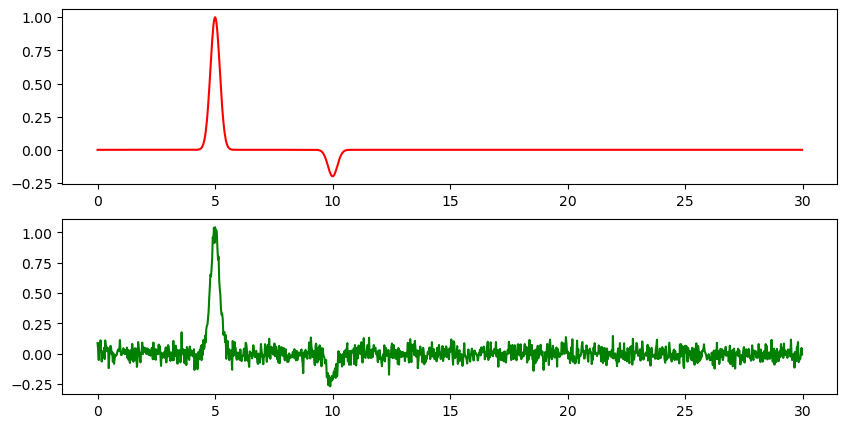

In [3]:
mean=0
standard_dev=0.05
npts_random=len(demo_tr)
random_noise=np.random.normal(mean, standard_dev, npts_random)
noisy_data=np.add(demo_tr.data,random_noise)
noisy_tr=Trace(header={'npts':len(noisy_data),'delta':demo_tr.stats.delta},data=noisy_data)
plt.figure(figsize=(10,5))
plt.subplot(211)
time1=np.arange(demo_tr.stats.npts)*demo_tr.stats.delta
plt.plot(time1,demo_tr.data,color='red')

plt.subplot(212)
time2=np.arange(noisy_tr.stats.npts)*noisy_tr.stats.delta
plt.plot(time2,noisy_tr.data,color='green')
plt.show()

In [4]:
def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging 
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

In [5]:
def spectral_whitening(arr, delta, freq_width, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.
    
    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr)
    carr = np.fft.fftshift(np.fft.fft(arr, 2*npts-1))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')
        
        carr /= weight
        carr[weight<1e-8] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]

### FFT and Spectral Whiten Plot

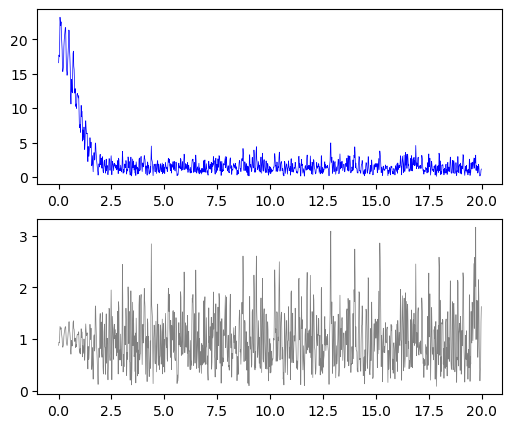

In [6]:
NF=0.5/noisy_tr.stats.delta
npts=noisy_tr.stats.npts
fft_tr=np.fft.fftshift(np.fft.fft(noisy_tr.data, 2*npts-1))[npts-1:2*npts]
new_delta=NF/len(fft_tr)
frequency1=np.arange(len(fft_tr))*new_delta

whiten_spectrum=spectral_whitening(noisy_tr.data,noisy_tr.stats.delta,1.0)
new_delta=NF/len(whiten_spectrum)
frequency2=np.arange(len(whiten_spectrum))*new_delta

plt.figure(figsize=(6,5.0))
plt.subplot(211)
plt.plot(frequency1,np.abs(fft_tr),color='blue',linewidth=0.5)
plt.subplot(212)
plt.plot(frequency2,np.abs(whiten_spectrum),color='gray',linewidth=0.5)
plt.show()

## Autocorrelation

The autocorrelation of a time trace is the inverse transform of the power spectrum.
The only causal part of the autocorrelation trace is retained. We use a cosine taper to the
central peak and apply bandpass filter to remove very high and low frequency.

### General autocorrelation 

In [7]:
def compute_auto(tr):
    delta=tr.stats.delta
    npts=tr.stats.npts
    fft_spectra=np.fft.fftshift(np.fft.fft(tr.data, 2*npts-1))[npts-1:2*npts]
    auto = np.fft.irfft(np.abs(fft_spectra)**2)
    auto_tr=Trace(header={'npts':len(auto),'delta':delta},data=auto)
    # post processing: tapering and filtering
    taper_width = 10/(auto_tr.stats.npts * auto_tr.stats.delta)
    auto_tr.taper(type='cosine', max_percentage=taper_width)
    return auto_tr

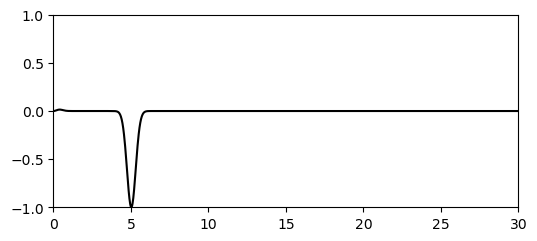

In [8]:
auto=compute_auto(demo_tr)
auto.normalize()
time=np.arange(auto.stats.npts)*auto.stats.delta

plt.figure(figsize=(6,2.5))
plt.plot(time,auto.data,color='black')
plt.xlim(0,30)
plt.ylim(-1,1)
plt.show()

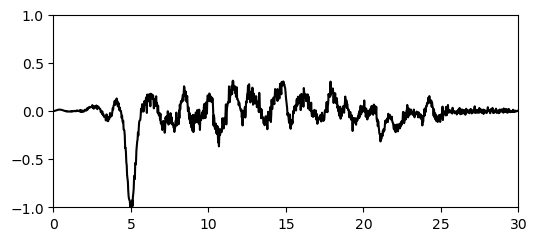

In [9]:
auto_noisy=compute_auto(noisy_tr)
auto_noisy.normalize()
time=np.arange(auto_noisy.stats.npts)*auto_noisy.stats.delta

plt.figure(figsize=(6,2.5))
plt.plot(time,auto_noisy.data,color='black')
plt.xlim(0,30)
plt.ylim(-1,1)
plt.show()

### Whiten autocorrelation

In [10]:
def compute_whiten_auto(tr,freq_width,lc,hc):
    delta=tr.stats.delta
    npts=tr.stats.npts
    whiten_spectrum=spectral_whitening(tr.data,tr.stats.delta,freq_width)
    w_auto = np.fft.irfft(np.abs(whiten_spectrum)**2)
    w_auto_tr=Trace(header={'npts':len(w_auto),'delta':delta},data=w_auto)
    # post processing: tapering and filtering
    taper_width = 10/(w_auto_tr.stats.npts * w_auto_tr.stats.delta)
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    w_auto_tr.filter('bandpass', freqmin=lc, freqmax=hc, corners=4, zerophase=True)
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    return w_auto_tr

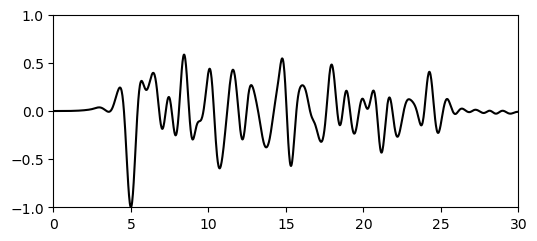

In [11]:
whiten_auto=compute_whiten_auto(noisy_tr,0.20,0.1,1.0)
whiten_auto.normalize()
time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta

plt.figure(figsize=(6,2.5))
plt.plot(time,whiten_auto.data,color='black')
plt.xlim(0,30)
plt.ylim(-1,1)
plt.show()


### Generate many noisy traces 

In [12]:
freq_width=0.40
lc=0.20
hc=1.0
auto_stream=Stream()
for i in range(1,31):
    time=np.arange(-2.5,2.5,0.025)
    sigma=0.2
    gauss_func1=Gaussian_function(time,sigma,0)
    gauss_func2=-0.2*Gaussian_function(time,sigma,0)
    #gauss_func3=0.1*Gaussian_function(time,sigma,0)
    demo_arr=np.concatenate((np.zeros(100),gauss_func1, gauss_func2,np.zeros(700)), axis = 0)
    #demo_arr=np.concatenate((np.zeros(100),gauss_func1, gauss_func2,gauss_func3,np.zeros(700)), axis = 0)
    demo_tr=Trace(header={'npts':len(demo_arr),'delta':0.025},data=demo_arr)
    demo_tr.normalize()
    
    mean=0
    standard_dev=0.05
    npts_random=len(demo_tr)
    random_noise=np.random.normal(mean, standard_dev, npts_random)
    noisy_data=np.add(demo_tr.data,random_noise)
    noisy_tr=Trace(header={'npts':len(noisy_data),'delta':demo_tr.stats.delta},data=noisy_data)
    whiten_auto=compute_whiten_auto(noisy_tr,freq_width,lc,hc)
    ###adding epicentral distance in file
    epi_dist=random.randint(30,95)
    sacd=AttribDict()
    sacd.gcarc=epi_dist
    whiten_auto.stats.sac = sacd
    ###############
    #print(whiten_auto.stats.sac.gcarc)
    auto_stream.append(whiten_auto)
print(len(auto_stream))

30


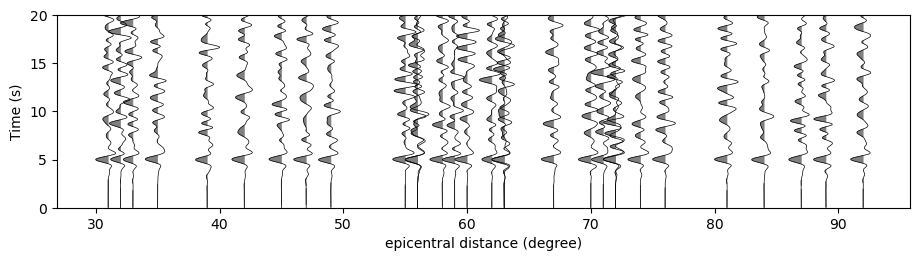

In [13]:
fig = plt.figure(figsize=(11, 2.5))
gs = gridspec.GridSpec(1, 1)
ax0=plt.subplot(gs[0,0])
for auto in auto_stream:
    time=np.arange(auto.stats.npts)*auto.stats.delta
    auto.data /= np.max(np.abs(auto.data))
    epi_dist = auto.stats.sac.gcarc
    ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
    ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
ax0.set_ylim(0,20)
ax0.set_xlabel("epicentral distance (degree)")
ax0.set_ylabel("Time (s)")
plt.show()

### Phase weighted stacking

Phase-weighted stacking is a nonlinear stacking technique to sufficiently enhance coherent signals and 
suppress noise [Schimmel and Paulssen, 1997]. It uses the averaging phase of the input traces to weight the
linear stack of the input.
The analytical signals of a one-sided autocorrelogram $s_n$ is given by
$$
S_n(t) = s_n(t) + i H_n(t) = A_n(t) e^{i\Phi_n(t)}
$$
where $H_n(t)$ is the Hilbert transform of the original trace $s_n(t)$. And, $A_n(t)$, $\Phi_n(t)$ are the amplitude and phase components of the analytic signal. The phase-weighted stack of $N$ input traces is defined as
$$
g(t) = \frac{1}{N} \sum_{n=1}^N s_n(t) \; \left|\frac{1}{N}\sum_{n=1}^N e^{i\Phi_n(t)}\right|^\eta.
$$
The order $\eta$ is used to adjust the importance of the phase weighting factor. When $\eta = 0$,
the 0th order phase-weighted stack becomes a linear stack.

In [14]:
def data_stack(stream, order):
    stack = 0
    phase = 0j
    
    if order == 0:
        for acorr in stream:
            stack += acorr.data
        stack /= len(stream)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)
    else:
        for acorr in stream:
            stack += acorr.data

            ## calculate phase
            asig = hilbert(acorr.data)
            phase += asig / np.abs(asig)
        stack /= len(stream)
        weight = np.abs(phase / len(stream))

        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)


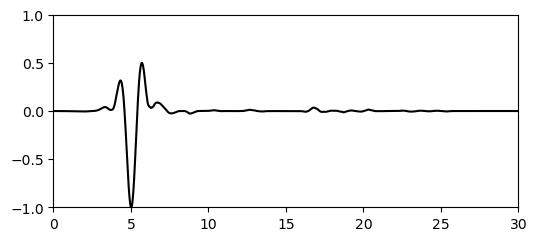

In [15]:
stack=data_stack(auto_stream,2)
stack.normalize()
plt.figure(figsize=(6,2.5))
time=np.arange(stack.stats.npts)*stack.stats.delta
plt.plot(time,stack.data,color='black')
plt.xlim(0,30)
plt.ylim(-1,1)
plt.show()

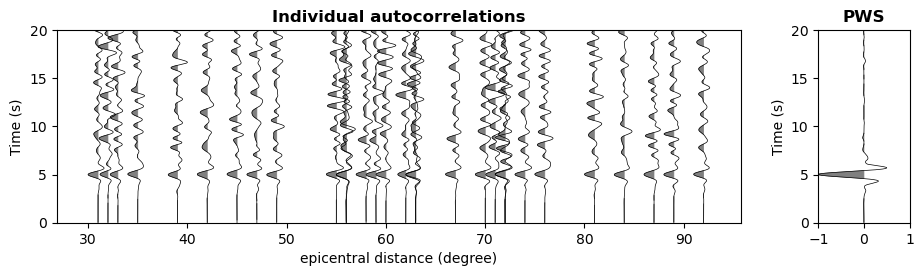

In [18]:
fig = plt.figure(figsize=(11, 2.5))
gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
ax0=plt.subplot(gs[0,0])
for auto in auto_stream:
    time=np.arange(auto.stats.npts)*auto.stats.delta
    auto.data /= np.max(np.abs(auto.data))
    epi_dist = auto.stats.sac.gcarc
    ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
    ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
ax0.set_ylim(0,20)
ax0.set_xlabel("epicentral distance (degree)")
ax0.set_ylabel("Time (s)")
ax0.set_title("Individual autocorrelations",weight='bold')

ax1=plt.subplot(gs[0,1])
stack=data_stack(auto_stream,2)
time=np.arange(stack.stats.npts)*stack.stats.delta
stack.normalize()
ax1.plot(stack.data, time, lw=0.5, color='black')
ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='gray', where=(stack.data < 0))
ax1.set_ylim(0,20)
ax1.set_xlim(-1,1)
ax1.set_ylabel("Time (s)")
ax1.set_title("PWS",weight='bold')

plt.show()